In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
stoi #itos would be reverse order mapping

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], [] # input and target output
  for w in words:
    #print(w)
    context = [0] * block_size # actual context flow
    for ch in w + '.': # adding the special stop character at the end
      ix = stoi[ch] # encode the character to integer
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# character embedding matrix, for 26 unique characters + 1 for the '.' character, with embedding dimension of 10
C = torch.randn((27, 10), generator = g)
# first layer weights and bias 
W1 = torch.randn((30, 200), generator = g) # 30 = 3 (block size) * 10 (embedding dimension), 200 hidden neurons
b1 = torch.randn(200, generator = g) # bias for the first layer
# second layer weights and bias
W2 = torch.randn((200, 27), generator=g) # 27 output classes
b2 = torch.randn(27, generator=g) # bias for the second layer
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [11]:
for p in parameters:
  p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [13]:
lri = []
lossi = []
stepi = []

In [17]:
ix = torch.randint(0, Xtr.shape[0], (32,))
ix

tensor([ 93918,  56872,  88818,  37058,   9113,   2578, 119379, 166607, 152342,
        119068, 160516, 108289,  64633,  52718,  48383,  50692,  54592,  88808,
         63004,  78056,   9619,   1060, 124124, 108096, 157961,  30516,  10359,
          3731,  58241, 166538,  98493, 136293])

In [22]:
Xtr[93918]

tensor([13,  1,  4])

In [21]:
Xtr[ix].shape

torch.Size([32, 3])

In [29]:
C[Xtr[93918]]

tensor([[-0.3111, -0.3060, -1.7495, -1.6335,  0.3876,  0.4724,  1.4830,  0.3175,
          1.0588,  2.3982],
        [-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404],
        [-0.9648, -0.2321, -0.3476,  0.3324, -1.3263,  1.1224,  0.5964,  0.4585,
          0.0540, -1.7400]], grad_fn=<IndexBackward0>)

In [28]:
C[Xtr[93918]].view(-1, 30)

tensor([[-0.3111, -0.3060, -1.7495, -1.6335,  0.3876,  0.4724,  1.4830,  0.3175,
          1.0588,  2.3982, -0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,
          1.5618, -1.6261,  0.6772, -0.8404, -0.9648, -0.2321, -0.3476,  0.3324,
         -1.3263,  1.1224,  0.5964,  0.4585,  0.0540, -1.7400]],
       grad_fn=<ViewBackward0>)

In [31]:
C[Xtr[ix]].shape

torch.Size([32, 3, 10])

In [32]:
for i in range(2_00_000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) tanh(x*w1 + b1)
  # 32*200 =  32 * 30 @ 30*200 + 200
  logits = h @ W2 + b2 # (32, 27)
  # 32*27 = 32*200 @ 200*27 + 27
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

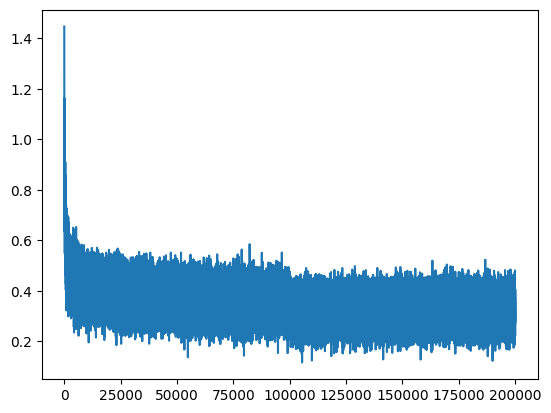

In [33]:
plt.plot(stepi, lossi)

In [ ]:
# Total training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1378, grad_fn=<NllLossBackward0>)

In [36]:
# Total validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1783, grad_fn=<NllLossBackward0>)

In [37]:
# Total test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1833, grad_fn=<NllLossBackward0>)

In [39]:
C.shape

torch.Size([27, 10])

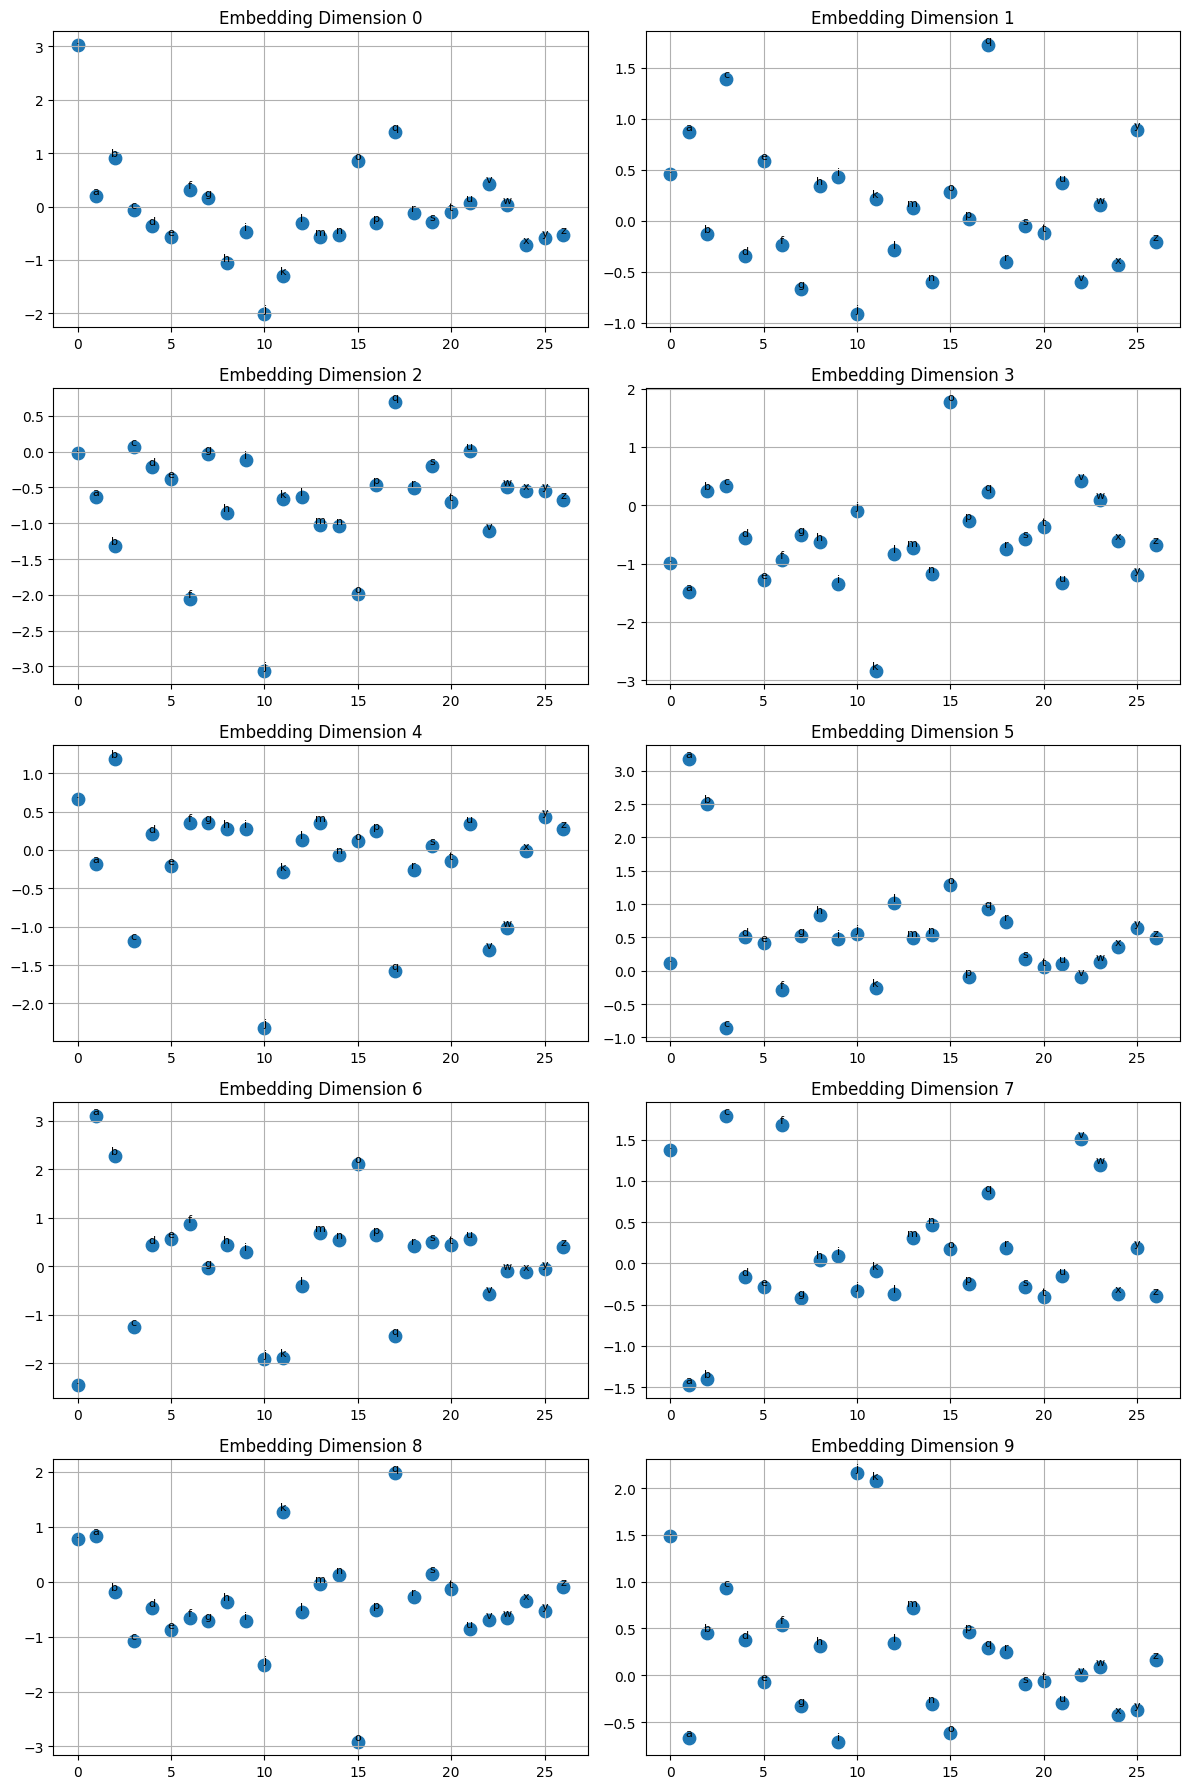

In [40]:
# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')


num_chars, emb_dim = C.shape

fig, axes = plt.subplots(5, 2, figsize=(12, 18))   # 10 subplots => 5 rows × 2 columns
axes = axes.flatten()

for dim in range(emb_dim):
    ax = axes[dim]
    ax.scatter(range(num_chars), C[:, dim].data, s=80)
    
    for i in range(num_chars):
        ax.text(i, C[i, dim].item(), itos[i], ha='center', va='bottom', fontsize=8)

    ax.set_title(f"Embedding Dimension {dim}")
    ax.grid(True)

# If there are empty axes (not in this case, but safe)
for ax in axes[emb_dim:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [44]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, d (embedding size))
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

chriah.
amille.
khi.
mili.
thiyah.
cassie.
mahiel.
delynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
pori.
quinn.
shoin.
alianni.
wauel.
giearyn.
kai.
